# EEG Localiser decoding

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook trains a classifier on the localiser data to identify the neural signature associated with each image in the task.

Classification steps:

1. Loading preprocessed data
2. Running classification over multiple trial timepoints to generate a decoding timecourse
3. Hyperparameter estimation
4. Producing a confusing matrix to assess classifier performance


## Imports

In [2]:
import sys
sys.path.insert(0, 'code')

import os
os.chdir('..')

from mne.io import read_raw_ctf
import mne
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, create_eog_epochs
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.externals import joblib
from scipy.stats import halfcauchy
from mne.decoding import (SlidingEstimator, cross_val_multiscore)
from mne.decoding import UnsupervisedSpatialFilter
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import papermill as pm
from utils import add_features
from plotting import plot_confusion_matrix

%matplotlib inline

np.random.seed(100)

## Parameters

In [3]:
session_id = 'e003'  # ID of the scanning session
output_dir = 'data/derivatives'  # Where the output data should go
n_stim = 7  # Number of stimuli, including null
shifts = [-5, 6]  # Additional timepoints to use as features
n_iter_search = 100  # Number of iterations of the random search parameter optimisation procedure
cores = 4  # Number of cores to use for parallel processing
os.environ['OMP_NUM_THREADS'] = str(cores)

## Get data

In [4]:
os.listdir(os.path.join(output_dir, 'preprocessing/localiser'))

['sub-e000_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz',
 'sub-e003_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz']

In [5]:
os.path.join(output_dir, 'preprocessing/localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id)

'data/derivatives\\preprocessing/localiser\\sub-e003_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz'

In [6]:
localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing/localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))

Reading data/derivatives\preprocessing/localiser\sub-e003_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Found the data of interest:
        t =    -100.00 ...     490.00 ms
        0 CTF compensation matrices available
503 matching events found
Applying baseline correction (mode: mean)
503 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


### Plot the responses to image stimuli in sensor space

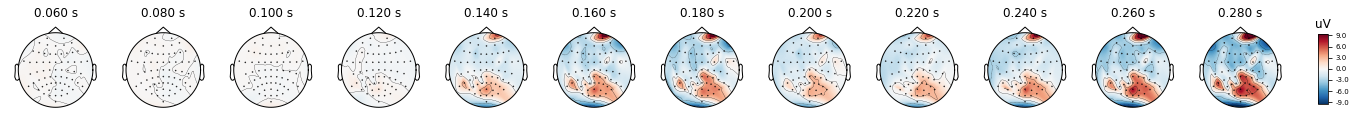

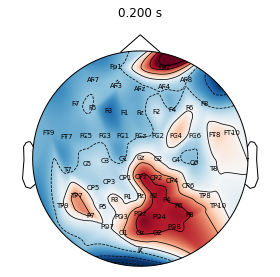

In [7]:
times = np.arange(0.06, 0.3, 0.02)
evoked = localiser_epochs.average()
evoked.plot_topomap(times, ch_type='eeg')
evoked.plot_topomap(0.2, ch_type='eeg', show_names=True, colorbar=False, size=3, res=128);

In [8]:
localiser_epochs

<EpochsFIF  |   503 events (all good), -0.1 - 0.49 sec, baseline [-0.1, 0], ~15.4 MB, data loaded,
 'stimulus_1': 69
 'stimulus_2': 70
 'stimulus_3': 56
 'stimulus_4': 79
 'stimulus_5': 70
 'stimulus_6': 77
 'stimulus_7': 82>

## Decoding analysis

### Timecourse of decoding accuracy

This gives us an idea of where in time we're able to decode stimulus identity - this should be around chance at 0s before rising a little before 200ms.

Number of unique events = 7

Event types = [1 2 3 4 5 6 7]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.8s finished


Best classification at index 32, 187ms


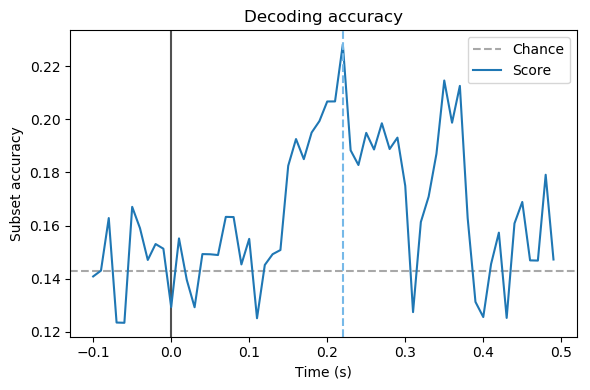

In [29]:
# Get epoch data
localiser_epochs = localiser_epochs.pick_types(eeg=True)
X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
y_raw = localiser_epochs.events[:600, 2].copy()  # Get event types

print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                  np.unique(y_raw)))

# Do PCA with 50 components
pca = UnsupervisedSpatialFilter(PCA(50), average=False)
pca_data = pca.fit_transform(X_raw)

# CLASSIFIER
# Logistic regression with L2 penalty, multi-class classification performed as one-vs-rest
# Data is transformed to have zero mean and unit variance before being passed to the classifier
clf = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', C=0.1, penalty='l2', class_weight="balanced",
                                                         solver='saga', tol=0.01))

# Try classifying at all time points with 5 fold CV
time_decod = SlidingEstimator(clf, n_jobs=4, scoring='accuracy')
scores = cross_val_multiscore(time_decod, pca_data, y_raw,
                              cv=3, n_jobs=4)

# Mean scores across cross-validation splits
mean_scores = np.mean(scores, axis=0)
best_idx = np.where(mean_scores == mean_scores.max())[0][0]

print("Best classification at index {0}, {1}ms".format(best_idx, (best_idx * 10) - 133))

# Plot
fig, ax = plt.subplots(dpi=100)
# ax.plot(range(10), mean_scores, label='Score')
ax.axhline(1. / n_stim, color='#a8a8a8', linestyle='--', label='Chance')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Subset accuracy')
ax.axvline(.0, color='#515151', linestyle='-')
ax.set_title('Decoding accuracy')
ax.plot(localiser_epochs.times[:len(mean_scores)], mean_scores, label='Score')
ax.axvline(localiser_epochs.times[best_idx], color='#76b9e8', linestyle='--')

ax.legend()
plt.tight_layout()

### Plot the response timecourse across trials

This just shows the responses across our principal components across all trials.

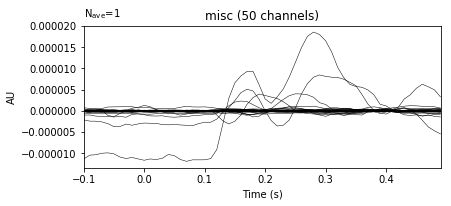

In [10]:
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(50, localiser_epochs.info['sfreq']), tmin=-0.1)
ev.plot(show=False, window_title="PCA", time_unit='s');

### Optimise hyperparameters using randomised search

Optimising regularisation parameter (C) and number of PCA components. Randomised search works like grid search but rather than exhaustively searching a grid of predefined parameter values, it samples from specified parameter distributions. This is useful here because C values closer to 0 tend to be better, but this is not always the case - here we sample C values from a half-Cauchy distribution so that low values are tested more frequently, without us having to manually specify a grid that conforms to this criterion.

To make the process more streamlined, we create a classifier pipeline containing the following steps:
1. Temporal PCA (reducing dimensionality in the channel dimension)
2. Adding features from adjacent timepoints - although we're focusing on the 200ms mark, we add timepoints from before and after this point as additional features. This tends to boost decoding accuracy by ~10%.
3. Scaling the data to be in a standard range.
4. Logistic regression with lasso (L2) regularisation and multinomial multi-class classification.

This is the iteratively run and evaluated with 3-fold cross validation across different hyperparameter settings.

All of this is performed on data from the 200ms point as this has been used successfully in previous studies - interestingly decoding from other timepoints doesn't seem to produce the kind of sequential replay we get when decoding from 200ms.


In [24]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Set idx to 33 for 200ms
best_idx = 30

# Select data from timepoint of interest
X, y = (X_raw.copy(), y_raw.copy())
X = X[..., best_idx + shifts[0]:best_idx + shifts[1]] 
X_null = X_raw[..., :11]
y_null = np.ones(len(y)) * 8
X = np.vstack([X, X_null])
y = np.hstack([y, y_null])

# Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), FunctionTransformer(add_features, validate=False), 
                    StandardScaler(), LogisticRegression(multi_class='multinomial', C=0.1, penalty='l2', class_weight="balanced",
                                                         solver='saga', tol=0.01))

# Parameter distributions passed to the random search procedure
param_dist = {"unsupervisedspatialfilter__estimator__n_components": range(10, 65),
              "logisticregression__C": halfcauchy(scale=5)}

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, n_jobs=4, scoring='accuracy')
random_search.fit(X, y)

# Produce a dataframe of the search results
results = pd.DataFrame(random_search.cv_results_)

print("Parameter optimisation done")


 Show the results of the optimisation procedure

In [17]:
results.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_unsupervisedspatialfilter__estimator__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
11,1.584284,0.090284,0.012300,0.000940,16.5085,42,"{'logisticregression__C': 16.5084641139, 'unsu...",0.646018,0.626866,0.593373,0.622266,0.021740,1,0.998501,0.995529,0.995549,0.996526,0.001396
6,1.316177,0.086292,0.011635,0.001695,4.04123,42,"{'logisticregression__C': 4.04122655216, 'unsu...",0.646018,0.626866,0.590361,0.621272,0.023067,2,0.998501,0.995529,0.995549,0.996526,0.001396
12,1.775770,0.179446,0.014295,0.001695,5.936,48,"{'logisticregression__C': 5.9359998824, 'unsup...",0.628319,0.629851,0.605422,0.621272,0.011142,2,1.000000,0.998510,0.994065,0.997525,0.002521
27,2.032248,0.227555,0.013298,0.001243,17.6166,39,"{'logisticregression__C': 17.6166096748, 'unsu...",0.634218,0.620896,0.602410,0.619284,0.013038,4,0.997001,0.997019,0.994065,0.996029,0.001388
17,1.849764,0.105467,0.014297,0.000939,1.95224,50,"{'logisticregression__C': 1.95223553615, 'unsu...",0.625369,0.608955,0.620482,0.618290,0.006891,5,1.000000,0.998510,0.995549,0.998020,0.001850


### Plot the results of hyperparameter optimisation

We can plot the results of the randomised search on a 3D mesh, with the two optimised parameters on the X and Y axes and accuracy on the Z axis. This is produced using [plotly](http://plot.ly/).

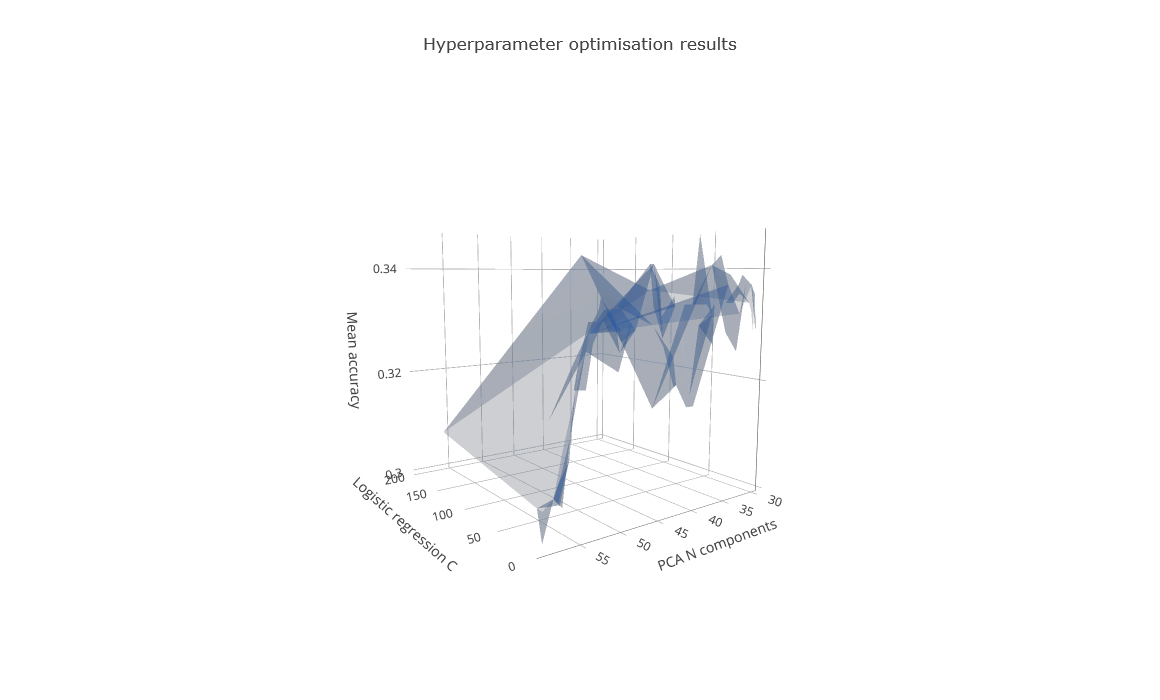

In [63]:
init_notebook_mode(connected=True)

trace = go.Mesh3d(x=results.param_logisticregression__C,
                  y=results.param_unsupervisedspatialfilter__estimator__n_components,
                  z=results.mean_test_score, 
                  color='#275fb5', opacity=0.20)

layout = go.Layout(
    title='Hyperparameter optimisation results',
    autosize=True,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(
        title='Logistic regression C'),
    yaxis = dict(
        title='PCA N components'),
    zaxis = dict(
        title='Mean accuracy'),)
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Make confusion matrix with 5-fold CV

The confusion matrix gives us an idea of whether any individual stimuli are being poorly decoded.

Mean accuracy = 0.6282306163021869


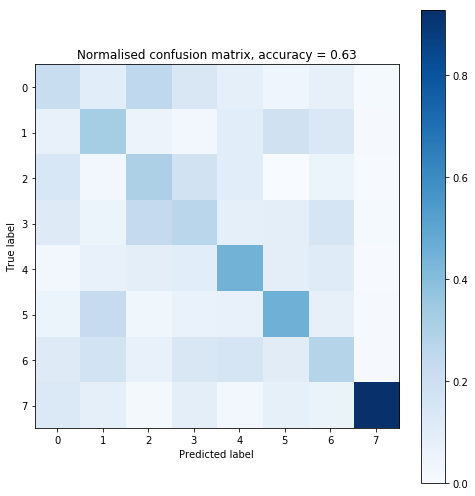

In [18]:
clf.set_params(**random_search.best_params_)

# Get predictions with 5 fold CV
y_pred = cross_val_predict(clf, X, y, cv=5)
mean_conf_mat = confusion_matrix(y, y_pred)
mean_accuracy = accuracy_score(y, y_pred)
mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise

print("Mean accuracy = {0}".format(mean_accuracy))
    
# Plot mean confusion matrix
plot_confusion_matrix(mean_conf_mat, title='Normalised confusion matrix, accuracy = {0}'.format(np.round(mean_accuracy, 2)))
plt.savefig('eeg_decoding_test.png')

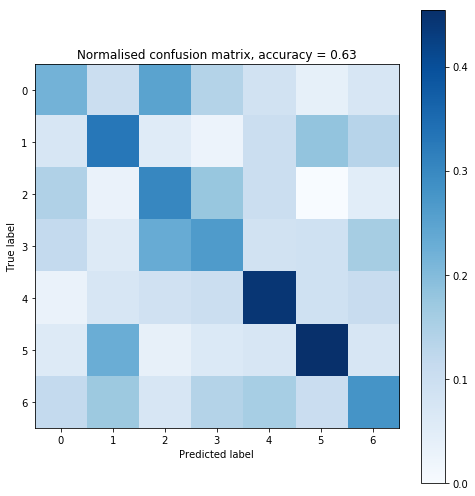

In [21]:
plot_confusion_matrix(mean_conf_mat[:7, :7], title='Normalised confusion matrix, accuracy = {0}'.format(np.round(mean_accuracy, 2)))

### Save components of the analysis for later use

First save the classifier that was fit to all the localiser data using the best hyperparameter values.

In [22]:
joblib.dump(random_search.best_estimator_ , os.path.join(output_dir, 'classifier', 'sub-{0}_classifier.pkl').format(session_id)) 

['data/derivatives\\classifier\\sub-e003_classifier.pkl']

We can use papermill to save certain details, such as the mean accuracy, in the notebook so that we can read them later on.

In [23]:
pm.record("mean_accuracy", mean_accuracy)
pm.record('best_C', random_search.best_params_['logisticregression__C'])
pm.record('best_n_components', random_search.best_params_['unsupervisedspatialfilter__estimator__n_components'])